In [11]:
#%pylab inline

from __future__ import division

import copy
import os 
import argparse
import numpy as np 

from astropy.io import fits 
from astropy    import wcs 

import lsst.daf.persistence   as dafPersist
import lsst.afw.coord         as afwCoord
import lsst.afw.image         as afwImage
import lsst.afw.geom          as afwGeom
import lsst.afw.table         as afwTable

# Matplotlib default settings
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 12, 10
mpl.rcParams['xtick.major.size'] = 8.0
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 8.0
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4.0
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rc('axes', linewidth=2)

# Shapely related imports 
from shapely.geometry import MultiPoint
from shapely          import wkb 
from shapely.ops      import cascaded_union 


from scipy import ndimage
from skimage.feature import corner_fast, corner_peaks

#from coaddPatchShape import polySaveWkb
#import cubehelix  # Cubehelix color scheme from https://github.com/jradavenport/cubehelix

In [75]:
def showHscMask(noData, title='No Data Mask Plane', 
                cmap='gray', corners=None, convex=None, 
                pngName=None):
    
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1,
                        top=0.95, right=0.95)

    ax = plt.gca()
    fontsize = 14
    ax.minorticks_on()

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.set_title(title, fontsize=25, fontweight='bold')
    ax.title.set_position((0.5,1.01))

    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.imshow(noData, cmap = plt.get_cmap(cmap), interpolation='none')
    
    if corners is not None: 
        for corner in corners: 
            ax.scatter(corner[1], corner[0], s=30.0, c='r')
    if convex is not None: 
        for p in convex: 
            ax.scatter(p[1], p[0], s=50.0, c='b')

    if pngName is not None:     
        fig.savefig(pngName)
        plt.close(fig)

In [76]:
def imgAddNoise(im): 
    
    im = ndimage.gaussian_filter(im, 2)
    im += 0.2 * np.random.random(im.shape)
    
    return im 

In [77]:
def getPixelRaDec(wcs, xx, yy): 
    
    coord = wcs.pixelToSky(xx, yy).toIcrs()
        
    ra  = coord.getRa().asDegrees()
    dec = coord.getDec().asDegrees()
    
    return ra, dec

In [78]:
def polySaveWkb(poly, wkbName):

    polyWkb = wkb.dumps(poly)

    wkbFile = open(wkbName, 'w')
    wkbFile.write(polyWkb.encode('hex'))
    wkbFile.close()

In [110]:
def polySaveReg(poly, regName): 
    
    # Get the coordinates for every point in the polygon 
    polyCoords = poly.boundary.coords[:]
    coordShow = map(lambda x: str(x[0]) + ' ' + str(x[1]) + ' ', polyCoords)
    
    # DS9 region file header 
    head1 = '# Region file format: DS9 version 4.1\n'
    head2 = 'global color=blue width=2\n'
    head3 = 'icrs\n'
    
    # The format for Polygon in DS9 is: 
    # Usage: polygon x1 y1 x2 y2 x3 y3 ...
    polyLine = 'polygon '
    for p in coordShow: 
        polyLine += p 
    
    regFile = open(regName, 'w')
    regFile.write(head1)
    regFile.write(head2)
    regFile.write(head3)
    regFile.write(polyLine + '\n')
    regFile.close()

In [116]:
def coaddPatchNoData(rootDir, tract, patch, filter, prefix='hsc_coadd', 
                     savePNG=False, verbose=True): 
    
    # Make a butler and specify the dataID 
    butler = dafPersist.Butler(rootDir)
    dataId = {'tract':tract, 'patch':patch, 'filter':filter}
    
    # Get the name of the input fits image
    if rootDir[-1] is '/': 
        fitsName = rootDir + 'deepCoadd/' + filter + '/' + str(tract).strip() + '/' + patch + '.fits'
    else: 
        fitsName = rootDir + '/deepCoadd/' + filter + '/' + str(tract).strip() + '/' + patch + '.fits'
    if not os.path.isfile(fitsName): 
        raise Exception('Can not find the input fits image: %s' % fitsName)
        
    # Get the name of the wkb and deg file
    noDataWkb = prefix + '_' + str(tract).strip() + '_' + patch + '_' + filter + '_nodata.wkb'
    noDataReg = prefix + '_' + str(tract).strip() + '_' + patch + '_' + filter + '_nodata.reg'
    # Get the name of the png file
    noDataPng = prefix + '_' + str(tract).strip() + '_' + patch + '_' + filter + '_nodata.png'
    
    if verbose: 
        print "## Reading Fits Image: %s" % fitsName
        
    # Get the exposure from the butler 
    calExp = butler.get('deepCoadd', dataId, immediate=True)
    # Get the WCS object of the exposure 
    #wcs = calExp.getWcs() 
    
    # Get the object for mask plane 
    mskImg = calExp.getMaskedImage().getMask() 
    
    # Extract the NO_DATA plane 
    noData = copy.deepcopy(mskImg)
    noData &= noData.getPlaneBitMask('NO_DATA')
    # Return the mask image array 
    noDataArr = noData.getArray()
    
    # Set all masked pixels to be 1
    noDataArr /= 256
    # Pad the 2-D array by a little 
    noDataArr = np.lib.pad(noDataArr, ((1, 1), (1, 1)), 'constant', constant_values=0)    
    
    # Add a little bit of noise to the mask plane 
    noDataNoise = imgAddNoise(noDataArr)
    
    # Segment the mask plane into different regions and label them 
    maskLabel, nMasks = ndimage.label(noDataNoise)
    # Check the number of masks that have been found
    if nMasks == 0: 
        if verbose: 
            print "No Masked Region has been Found!"
    else: 
        if verbose: 
            print "%d regions have been detected" % nMasks
        
        # Get the sizes of each mask regions 
        maskSizes = ndimage.sum(noDataNoise, maskLabel, range(nMasks + 1))
        # Find the largest patch 
        maskLarge = (maskLabel == np.argmax(maskSizes))
        
        # 
        minMaskArea = (noDataArr.shape[0] * noDataArr.shape[1]) * 0.05
        if np.max(maskSizes) >= minMaskArea: 
        
            # Find the corners of the largest region 
            maskCorners = corner_peaks(corner_fast(maskLarge, 9), min_distance=1)
            if verbose: 
                print "%d corners have been detected" % maskCorners.shape[0]
        
            # Create a MultiPoint objects using these corners
            maskPoints = MultiPoint(maskCorners)
            # Get its convex_hull and make a Polygon 
            maskConvex = maskPoints.convex_hull
        
            # Expand the offset a little bit to account for the padding and noise-adding
            maskBound  = maskConvex.boundary
            maskOffset = maskBound.parallel_offset(9, 'left', join_style=2)
            # Get the coordinates of the simplified 
            maskCoords = maskOffset.coords[:]
        
            # Read in the original image and get the wcs 
            # This is not perfect
            hduList = fits.open(fitsName)
            header = hduList[1].header 
            w = wcs.WCS(header)
        
            # Get the Ra Dec coordinates of the corner
            maskSkyCoords = map(lambda x: (x[1], x[0]), maskCoords)
            maskRaDec = w.wcs_pix2world(maskSkyCoords, 1)

            # Get the shape of the NO_DATA region in unit of [Ra, Dec]
            noDataCorners = MultiPoint(maskRaDec)
            noDataConvex  = noDataCorners.convex_hull
            noDataCoords  = noDataConvex.boundary.coords[:]
        
            # Show the NO_DATA mask plane and its corners
            if savePNG: 
                showHscMask(maskLarge, 'NO_DATA Mask Plane', 
                            corners=maskCorners, convex=maskCoords, 
                            pngName=noDataPng)
        
            # Save this polygon as a .wkb file 
            polySaveWkb(noDataConvex, noDataWkb)
            # Save this polygon as a .reg file 
            polySaveReg(noDataConvex, noDataReg)
            
        else: 
            print "No useful mask has been found!"
            noDataConvex = None
        
    return noDataConvex

In [117]:
# Example 

rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight'
tract   = 0
patch   = '0,6' 
filter  = 'HSC-I'

In [93]:
noDataConvex = coaddPatchNoData(rootDir, tract, patch, filter, 
                                prefix='ssp341_cosmos', savePNG=True)

## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/0,6.fits
3 regions have been detected
36 corners have been detected


In [113]:
def listAllImages(rootDir, filter):

    import glob

    if rootDir[-1] is '/':
        searchDir = rootDir + 'deepCoadd/' + filter.upper() + '/*/*.fits'
    else:
        searchDir = rootDir + '/deepCoadd/' + filter.upper() + '/*/*.fits'

    return map(lambda x: x, glob.glob(searchDir))

In [120]:
def batchPatchNoData(rootDir, filter='HSC-I', prefix='hsc_coadd'): 
    
    # Get the list of coadded images in the direction 
    imgList = listAllImages(rootDir, filter) 
    # Get the list of tract and patch for these images 
    tract = map(lambda x: int(x.split('/')[-2]), imgList)
    patch = map(lambda x: x.split('/')[-1].split('.')[0], imgList)
    
    noDataList = map(lambda x,y: coaddPatchNoData(rootDir, x, y, filter, 
                        prefix=prefix, savePNG=True), tract, patch)
    
    # Select the non-empty ones 
    noDataUse = []
    for shape in noDataList:
        if shape is not None: 
            noDataUse.append(shape)
    
    # Make a cascaded union of them 
    noDataComb  = cascaded_union(noDataUse)
    # Save this polygon as a .wkb file 
    polySaveWkb(noDataComb, prefix + '_' + filter + '_nodata_combined.wkb')
    
    return noDataUse, noDataComb

In [121]:
# Example of batch mode 
rootDir = '/lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight'
prefix  = 'ssp341_cosmos'
filter  = 'HSC-I'

cosI_nodata, cosI_combined = batchPatchNoData(rootDir, filter=filter, prefix=prefix)

## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/4,2.fits
11 regions have been detected
No useful mask has been found!
## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/10,4.fits
1 regions have been detected
21 corners have been detected
## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/7,2.fits
12 regions have been detected
No useful mask has been found!
## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/3,4.fits
11 regions have been detected
No useful mask has been found!
## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/6,1.fits
5 regions have been detected
10 corners have been detected
## Reading Fits Image: /lustre/Subaru/SSP/rerun/yasuda/SSP3.4.1_cosmos_setWeight/deepCoadd/HSC-I/0/7,7.fits
6 regions have been detected
No useful mask has be

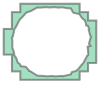

In [122]:
cosI_combined